<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/01_neural_network_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import (Dense, Dropout)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler
)
from sklearn import metrics

# **Funcitions**
---

In [4]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except Exception as e:
        print(e)

  except Exception as e:
    print(e)

def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()



def matrix_confusion(
    y_true:pd.Series,
    y_pred:pd.Series,
    churm:str='True',
    no_churm:str='False',
    title:str='Matriz de confusion',
    x_size:int=6,
    y_size:int=5,
    **kwards)->np.ndarray:
    """confusion matrix"""
    try:
      matrix = metrics.confusion_matrix(y_true, y_pred)
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(x_size, y_size))
      sns.heatmap(matrix, annot=True, ax=ax, fmt='g', **kwards)
      ax.set_title(title,size=20)
      ax.xaxis.set_ticklabels([no_churm,churm])
      ax.yaxis.set_ticklabels([no_churm,churm])
      ax.tick_params(labelsize = 12)
      fig.show()
      return matrix
    except Exception as e:
      print(e)

def optimization_learning_curves(
    history:dict,
    metrica:str,
    title:str='',
    X_size:int=8,
    y_size:int=4,
    font_size:int=15,
    X_label:str='Epoch',
    y_label:str='Loss'
)->None:
  """ Grafica curvas de aprendizaje """
  fig, ax = plt.subplots(figsize=(X_size, y_size))
  fig.suptitle(title, fontsize=font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(X_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper right', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

# **config**
---

In [5]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
title_data = 'Diabetes'
paleta = sns.color_palette('tab10').as_hex()
keras.utils.set_random_seed(random_seed)

# **Objetivos**
---
- Entender y codificar sobre el conjunto de datos en el problema de diagnosticar si un paciente mujer tiene o no diabetes del pueblo pima:
 - curvas de aprendizaje
 - sesgo de predicción
 - matrix confusión
 - Metricas
   - Accuracy
   - Kappa     
   - Precision
   - Recall
   - Specificity
   - F1-score
 - Precision-recall




## **Dicionario de datos**
---
- `Pregnancies` : número de veces de embarazo
- `Glucose` : concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia oral a la glucosa
- `BloodPressure`: presión arterial diastólica (mm Hg)
- `SkinThickness`: grosor del pliegue cutáneo del tríceps (mm)
- `Insulin` : insulina sérica de 2 horas (mu U/ml)
- `BMI` : Índice de masa corporal (peso en kg/(altura en m)^2)
- `DiabetesPedigreeFunction`: función de pedigrí de diabetes
- `Age`: edad
- `Outcome`: está enfermo?

In [6]:
url='https://drive.google.com/file/d/1FGFPdobSr2bMdYJOou-qWV8pJ1iOiW5d/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

In [7]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [8]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']] =  data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']].astype('int32')



data[[
    'BMI',
    'DiabetesPedigreeFunction']] = data[['BMI',
                                         'DiabetesPedigreeFunction']].astype('float32')

# **Data Split**
---

In [10]:
X = data.iloc[:, :8]
y = data.iloc[:, 8]

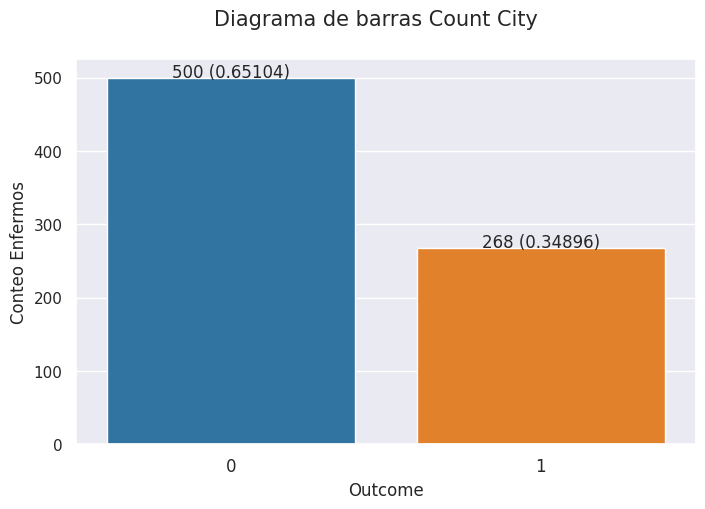

In [11]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='Outcome',
    ejey='Conteo Enfermos',
    title='Count City', p=True)

In [17]:
500/268

1.8656716417910448

In [23]:
1.86*268

498.48

In [12]:
print("""
Se presenta un desbalance significativo, pero no extremo,
por cada persona con posible diabetes, hay aproximadamente 1.8 personas sanas""")


Se presenta un desbalance significativo, pero no extremo,
por cada persona con posible diabetes, hay aproximadamente 1.8 personas sanas


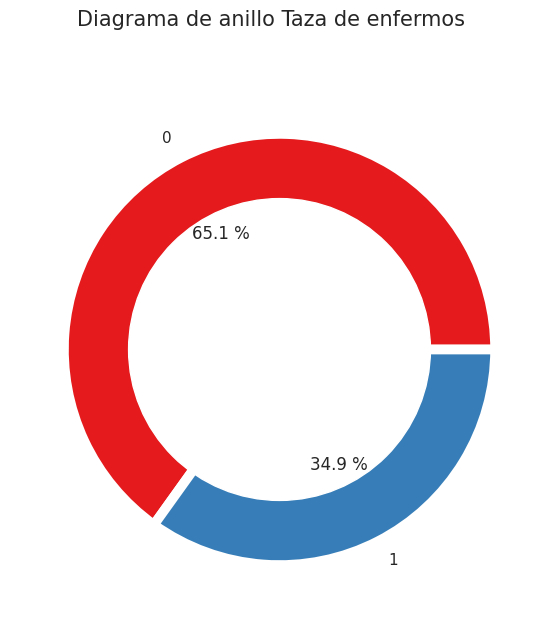

In [24]:
pie_circle(data['Outcome'], title='Taza de enfermos')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True
)

In [26]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [28]:
numeric_cosl = X_train.select_dtypes(include=['float32', 'int32']).columns.to_list()
numeric_cosl

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [29]:
numeric_transformer = Pipeline(
    steps = [
        ('scaler', MinMaxScaler())
    ]
)

In [31]:
numeric_transformer

Pipeline(steps=[('scaler', MinMaxScaler())])

In [32]:
numeric_transformer.fit(X_train)
X_train_prep = numeric_transformer.transform(X_train)
X_test_prep = numeric_transformer.transform(X_test)

In [33]:
X_train_prep

array([[0.35294118, 0.40201005, 0.6557377 , ..., 0.59314456, 0.04227156,
        0.1372549 ],
       [0.58823529, 0.89949749, 0.57377049, ..., 0.52309984, 0.05209223,
        0.31372549],
       [0.41176471, 0.47236181, 0.52459016, ..., 0.49627422, 0.2818104 ,
        0.39215686],
       ...,
       [0.41176471, 0.98492462, 0.73770492, ..., 0.59314456, 0.15926558,
        0.39215686],
       [0.05882353, 0.81909548, 0.59016393, ..., 0.58122207, 0.48847138,
        0.23529412],
       [0.17647059, 0.40201005, 0.67213115, ..., 0.50968706, 0.51836038,
        0.11764706]])

# **Model**
---

Se implementara dos arquitecutras de redes neuronales para este ejercicio

**Modelo 1**

In [34]:
model_uno = Sequential()
model_uno.add(
    Dense(6, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
model_uno.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))

model_uno.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        keras.metrics.Recall()
    ]
)

In [35]:
history_uno = model_uno.fit(
    X_train_prep,
    y_train,
    validation_data = (X_test_prep, y_test),
    epochs = 500,
    batch_size = 16,
    verbose=0
)

In [36]:
768/16

48.0

48.0 lotes con 16 registros para actualizar la red neuronal.

In [37]:
model_uno.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 54        
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history_uno.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

- Es de interés la reducción de los falsos negativos

**Modelo 1**

In [39]:
model_dos = Sequential()
model_dos.add(
    Dense(6, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
model_dos.add(
    Dense(2, activation='relu', kernel_initializer='glorot_uniform')
)
model_dos.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))


model_dos.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics=[
        'accuracy',
        keras.metrics.Recall()
    ]
)

In [40]:
history_dos = model_dos.fit(
    X_train_prep,
    y_train,
    validation_data = (X_test_prep, y_test),
    epochs=500,
    batch_size=16,
    verbose=0
)

In [41]:
model_dos.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 2)                 14        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history_dos.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'val_loss', 'val_accuracy', 'val_recall_1'])

# **Curva de aprendizaje**
---

## **Curvas de aprendizaje de optimización**
---



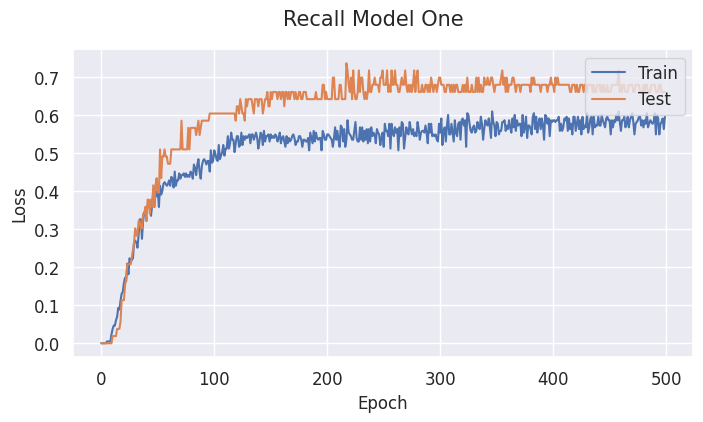

In [43]:
optimization_learning_curves(history_uno, metrica='recall', title='Recall Model One')

- Ambos modelos a nivel predictivo con los datos de validación tienen un buen comportamiento.

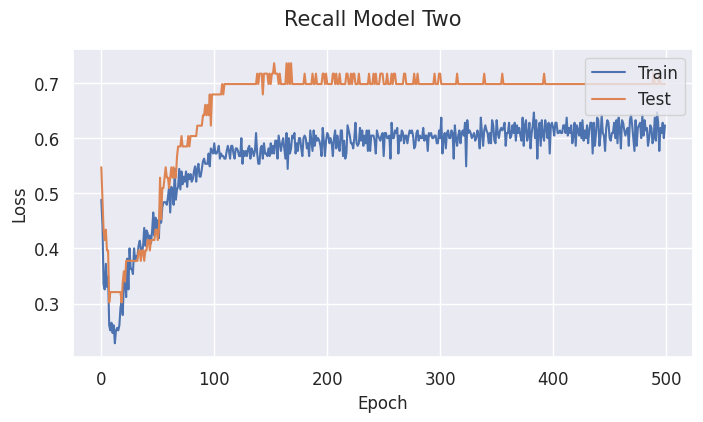

In [ ]:
optimization_learning_curves(history_dos, metrica='recall_1', title='Recall Model Two')

- Ambos modelos a nivel predictivo con los datos de validación tienen un buen comportamiento.

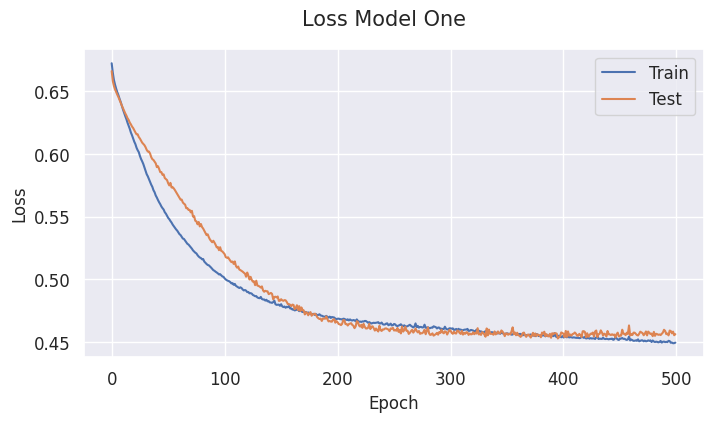

In [44]:
optimization_learning_curves(history_uno, metrica='loss', title='Loss Model One')

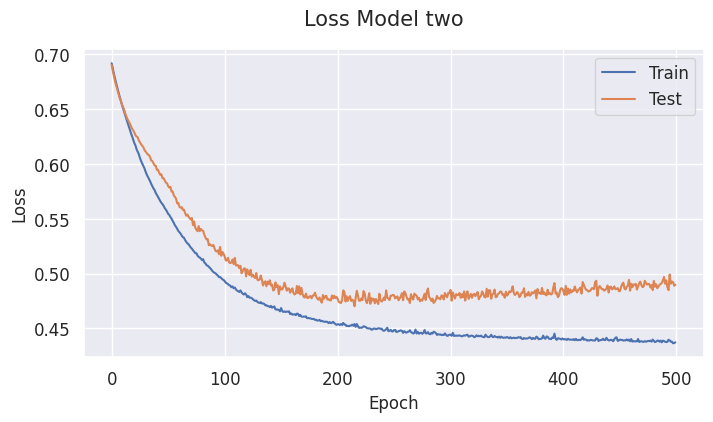

In [45]:
optimization_learning_curves(history_dos, metrica='loss', title='Loss Model two')

- El modelo uno tiene un buen rendimiento al momento de predecir la clase positiva cuando este en realidad sucede. Tiene una convergencia aproximadamente en la época 400.

- La arquitectura dos es más compleja que la uno, tiene un mejor comportamiento en el rendimiento con la métrica de sensibilidad, sin embargo, su rendimiento tiende al overfitting desde las primeras épocas.  Los datos de entrenamiento y validación son representativos para este conjunto de datos.



# **PRECISION-RECALL  -   CURVAS-ROC**
---

In [46]:
print("""
Se presenta un desbalance significativo, pero no extremo,
por cada persona con posible diabetes, hay aproximadamente 1.8 personas sanas""")


Se presenta un desbalance significativo, pero no extremo,
por cada persona con posible diabetes, hay aproximadamente 1.8 personas sanas


Como el desbalance no es tán significativo, se procede a validar las curvas ROC y las curvas de precisión-sensibilidad, donde la última se emplea, por el desbalance, que si bien no es tán crítico existe.

In [47]:
y_prob_one = model_uno.predict(X_test_prep)
y_prob_one = np.reshape(y_prob_one, y_prob_one.shape[0])
# AUC
roc_auc_score_one = roc_auc_score(y_test, y_prob_one)
print('Modelo One: ROC AUC=%.3f' % (roc_auc_score_one))

# ROC
fpr_one, tpr_one, _ = roc_curve(y_test, y_prob_one)

# Recall-Precision
precision_one, recall_one, _ = precision_recall_curve(y_test, y_prob_one)

# AUC Recall-Precision
auc_score_one = auc(recall_one, precision_one)
print('Modelo One: AUC PRECISION RECALL=%.3f' % (auc_score_one))


5/5 [==============================] - 0s 3ms/step
Modelo One: ROC AUC=0.879
Modelo One: AUC PRECISION RECALL=0.732


In [48]:
y_prob_dos = model_dos.predict(X_test_prep)
y_prob_dos = np.reshape(y_prob_dos, y_prob_dos.shape[0])
# AUC
roc_auc_score_dos = roc_auc_score(y_test, y_prob_dos)
print('Modelo Two: ROC AUC=%.3f' % (roc_auc_score_dos))

# ROC
fpr_dos, tpr_dos, _ = roc_curve(y_test, y_prob_dos)

# Recall-Precision
precision_dos, recall_dos, _ = precision_recall_curve(y_test, y_prob_dos)

# AUC Recall-Precision
auc_score_dos = auc(recall_dos, precision_dos)
print('Modelo Two: AUC PRECISION RECALL=%.3f' % (auc_score_dos))

5/5 [==============================] - 0s 2ms/step
Modelo Two: ROC AUC=0.871
Modelo Two: AUC PRECISION RECALL=0.705


In [49]:
y_prob_no_sklill = [0 for _ in range(len(y_test))]
roc_auc_score_no_skill = roc_auc_score(y_test, y_prob_no_sklill)
# AUC
print('No skill: ROC AUC=%.3f' % (roc_auc_score_no_skill))


# ROC
fpr_nkill, tpr_nkill, umbrales_nkill = roc_curve(y_test, y_prob_no_sklill)

No skill: ROC AUC=0.500


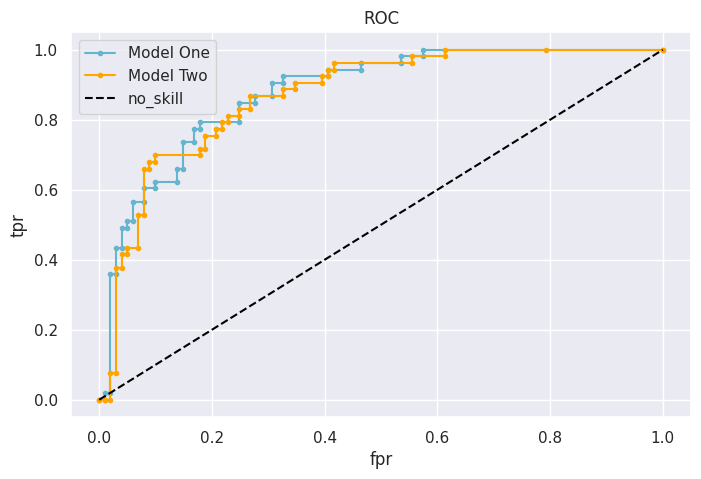

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(fpr_one, tpr_one, marker='.', label='Model One', color = 'c')
plt.plot(fpr_dos, tpr_dos, marker='.', label='Model Two', color = 'orange')
plt.plot(fpr_nkill, tpr_nkill, linestyle='--', label='no_skill', color = 'black')
plt.title('ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()

El modelo uno y el dos, tienen bajos niveles de falsos negativos y de falsos positivos, lo que indican un buen rendimiento en la precisión de la clase de interés, además como la tasa de falsos positivos es baja, los modelos tienen un buen comportamiento con respecto a la clase de no interés también, por su verdaderos negativos.

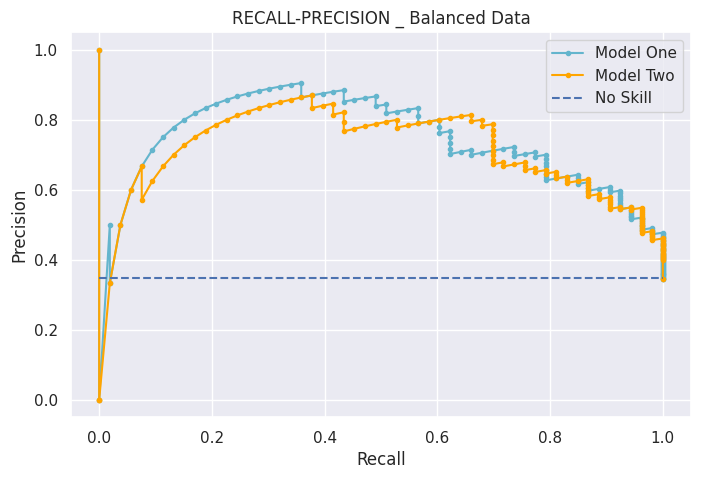

In [51]:
no_skill_curve_recall_presicion = len(y[y==1]) / len(y)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(recall_one, precision_one, marker='.', label='Model One', color = 'c')
plt.plot(recall_dos, precision_dos, marker='.', label='Model Two', color = 'orange')
plt.plot(
    [0, 1],
     [no_skill_curve_recall_presicion, no_skill_curve_recall_presicion],
    linestyle='--', label='No Skill')
plt.title('RECALL-PRECISION _ Balanced Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Ambos modelos tienen un rendimiento bueno en la detección de la clase positiva, sin embargo, el rendimiento no necesariamente es el óptimo, para el problema de detectar una afección médica.

# **Predictions**
---

In [52]:
y_pred_one = (model_uno.predict(X_test_prep)>0.5).astype('int32')
y_pred_two = (model_dos.predict(X_test_prep)>0.5).astype('int32')

5/5 [==============================] - 0s 2ms/step


In [53]:
y_pred_one = np.reshape(y_pred_one, y_pred_one.shape[0])
y_pred_two = np.reshape(y_pred_two, y_pred_two.shape[0])

In [54]:
# Sesgo predictivo
#sesgo predicción = promedio de predicciones - promedio de etiquetas (observaciones) en el conjunto de datos
def sesgo_prediction(y_pred:pd.Series,
                     y_valid:pd.Series,
                     target:int)->tuple:
  """ Calcula el sesgo de predicción """
  average_prediction = (len(y_pred[y_pred==target])) / len(y_pred)
  average_label_target = (len(y_valid[y_valid==target])) / len(y_valid)
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [55]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(
    y_pred_one,
    y_test,
    1)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

Promedio de predicciones:  0.3246753246753247
Promedio de etiquetas: 0.34415584415584416
Sesgo de predicción: -0.019480519480519487


- Tiene un sesgo de aproximadamente del -0.019%, el modelo subestima, tiene un porcentaje de errores de no predicciones de pacientes con diabetes

In [56]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(
    y_pred_two,
    y_test,
    1)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

Promedio de predicciones:  0.33766233766233766
Promedio de etiquetas: 0.34415584415584416
Sesgo de predicción: -0.006493506493506496


- Tiene un sesgo de aproximadamente del -0.0065, el modelo subestima, tiene un porcentaje de errores de no predicciones de pacientes con diabetes

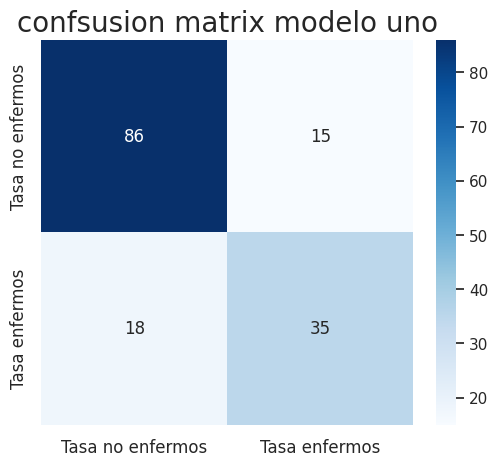

In [57]:
kward={"cmap":"Blues",  "annot_kws":{'size': 12}}
matrix = matrix_confusion(
    y_test,
    y_pred_one,
    title='confsusion matrix modelo uno',
    churm='Tasa enfermos',
    no_churm='Tasa no enfermos', **kward)

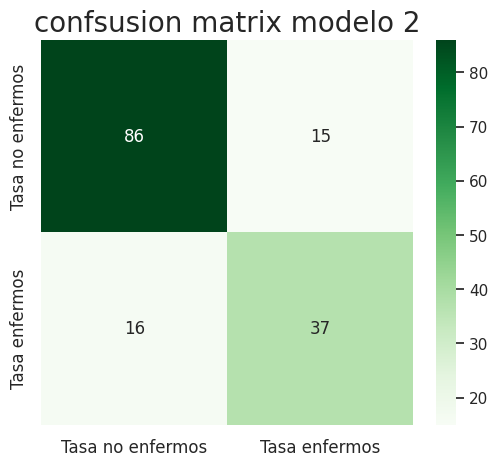

In [ ]:
kward={"cmap":"Greens",  "annot_kws":{'size': 12}}
matrix = matrix_confusion(
    y_test,
    y_pred_two,
    title='confsusion matrix modelo 2',
    churm='Tasa enfermos',
    no_churm='Tasa no enfermos', **kward)

Ambos modelos presenta un rendimiento regular, pero con un comportamiento muy similar, sin embargo, el modelo dos se comporta ligeramente mejor, aunque es el que tiende a presentar overfitting desde las primeras épocas. Para el número de registros, ambos tiene un porcentaje considerable de falsos negativos, ya que detecta enfermos como sanos, poniendo en riesgo a las personas, se presenta el erro tipo 2. Como el conjunto de datos tiene desbalance, nos fijamos en la sensibilidad para detectar los enfermos, cuando realidad es enfermo

In [58]:
def metricas(validation, prediction, matrix, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(
      validation, prediction, labels=label, average="micro")
  recall = '%.3f' % metrics.recall_score(
      validation, prediction, labels=label, average="micro")
  f1_score = '%.3f' % metrics.f1_score(
      validation, prediction, labels=label, average="micro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [59]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(
    y_test,
    y_pred_one,
    matrix)

Accuracy  :   0.786
Kappa     :   0.519
predicción enfermos
Precision:   0.700
Recall    :   0.660
Specificity:   0.851
F1-score   :   0.680


In [60]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(
    y_test,
    y_pred_two,
    matrix)

Accuracy  :   0.799
Kappa     :   0.552
predicción enfermos
Precision:   0.712
Recall    :   0.698
Specificity:   0.851
F1-score   :   0.705


- La sensibilidad es muy bajita, para mabos modelos, el modelo no seria el indicado, para un problema tán critico como detección de una enfermedad, sin embargo el modelo dos tiene un comportamiento ligeramente mejor que el modelo uno.

Como el proposito del proyecto, esta enfocado al autoaprendizaje no se aplicaron todas las tecnicas y conocimientos requeridos, sin embargo se realizaron variaciones en los hiperparametros, asi como manipular la estructura de la red y los valores en la partición de los datos.

**Tambien se aclara que el problema se pudo abordar mejor con otro timo de modelos de clasificación, sin embargo ese no hacia parte del objetivo, ya que se pretendia aprender sobre modelos de deep learning.**